### libraries Needed

In [1]:
import numpy as np # linear algebra
import pandas as pd # for data analysis
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback, EarlyStopping

import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

## Saparation of Label from the training set

In [2]:
path = '/kaggle/input/dlai7-digit-recognizer/'

train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path +'test.csv')

## SET Random Seed

In TensorFlow, you can fix the random seed to make your training process deterministic and reproducible. This ensures that when you run the same code with the same seed, you'll get identical results each time.

In [3]:
# Set random seeds
seed_value = 786
tf.random.set_seed(seed_value)
np.random.seed(seed_value)

## Saparation of Label from the training set



In [4]:
labels = train['label']
train.drop(['label'], axis= 1,  inplace = True)

## Split the data in train and validation set

In [5]:
split = int(int(train.size/(28*28))*0.99) 
train_set = train[0:split]
val_set   = train[split:]
train_label = labels[0:split]
val_label   = labels[split:]

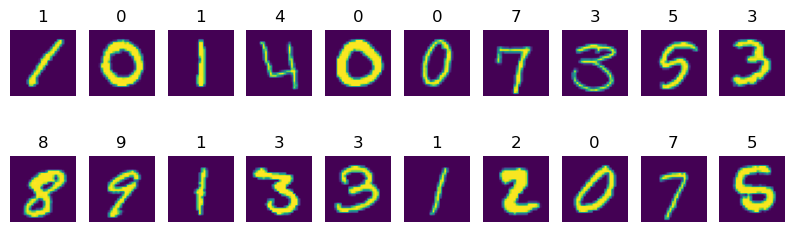

In [6]:
train_set_display = np.array(train_set.values).reshape(-1, 28, 28)

figure, axes = plt.subplots(2, 10, figsize=(10, 3))
axes = axes.ravel()

for index in range(0,20):
    axes[index].imshow(train_set_display[index])
    axes[index].set_title(train_label[index])
    axes[index].axis("off")


## Changing the shape of test set and normalization of test set



In [7]:
test_set = np.array(test.values).reshape(-1, 28, 28)
#test_input = tf.image.per_image_standardization(test_set)
test_input = test_set/255.

## Data reshapping and normalization of train and validation set of data



In [8]:
def train_val_generators(training_images, training_labels, validation_images, validation_labels):
  #reshaping the train and validation set
  training_images = np.array(training_images.values).reshape(-1, 28, 28)
  validation_images = np.array(validation_images.values).reshape(-1, 28, 28)
  training_images = np.expand_dims(training_images,axis = -1)
  validation_images =np.expand_dims(validation_images, axis =-1)
    # Normalization of train and validation set 
  train_datagen = ImageDataGenerator(rescale = 1./255,
                                    rotation_range=20,
                                    zoom_range = 0.1, # Randomly zoom image 
                                    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
                                    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
                                    horizontal_flip=False,  # randomly flip images
                                    vertical_flip=False)  # randomly flip images
    # setting the batch size to 128
  train_generator = train_datagen.flow(x=training_images, y=training_labels, batch_size=128)

  validation_datagen = ImageDataGenerator(rescale = 1./255)

  validation_generator = validation_datagen.flow(x=validation_images, y=validation_labels, batch_size=128)

  return train_generator, validation_generator

Data reshapping and normalization

In [9]:
train_input, val_input = train_val_generators(train_set, train_label, val_set, val_label)

In [10]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 28x28 with 1 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(32, (5,5), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.BatchNormalization(), 
    # The second convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.BatchNormalization(), 
    # The 3rd convolution
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.BatchNormalization(), 
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
   # tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(64, activation='relu'),

    tf.keras.layers.Dense(10, activation='softmax')
    ])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 32)        832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 12, 12, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 128)       36992     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 128)        0         
 2D)                                                             
                                                        

Adam is being used as an optimizer and Sparse Categorical Cross entropy as a loss function as it has more then 2 outputs

In [11]:
# Compile the model with Adam optimizer and user-defined learning rate
initial_learning_rate = 0.005  # Replace this with your desired initial learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [12]:
#model.compile(optimizer = 'Adam',
#                loss = 'sparse_categorical_crossentropy',
 #               metrics=['accuracy'])


In [13]:
# Create early stopping callback based on training loss
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, monitor='loss', restore_best_weights=True)

# Create learning rate scheduler callback
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=5, monitor='loss', verbose=1, min_lr = 0.000001)


## Model Training¶
finally training with cross validation set

In [14]:
history = model.fit(train_input,
                    #validation_data=val_input,
                    callbacks=[early_stopping, lr_scheduler],
                    epochs=100 )


Epoch 1/100
325/325 [==============================] - 24s 44ms/step - loss: 0.2601 - accuracy: 0.9186 - lr: 0.0050
Epoch 2/100
325/325 [==============================] - 14s 44ms/step - loss: 0.1249 - accuracy: 0.9625 - lr: 0.0050
Epoch 3/100
325/325 [==============================] - 14s 44ms/step - loss: 0.1009 - accuracy: 0.9707 - lr: 0.0050
Epoch 4/100
325/325 [==============================] - 15s 48ms/step - loss: 0.0925 - accuracy: 0.9738 - lr: 0.0050
Epoch 5/100
325/325 [==============================] - 15s 46ms/step - loss: 0.0803 - accuracy: 0.9767 - lr: 0.0050
Epoch 6/100
325/325 [==============================] - 15s 46ms/step - loss: 0.0738 - accuracy: 0.9797 - lr: 0.0050
Epoch 7/100
325/325 [==============================] - 14s 44ms/step - loss: 0.0708 - accuracy: 0.9804 - lr: 0.0050
Epoch 8/100
325/325 [==============================] - 15s 45ms/step - loss: 0.0663 - accuracy: 0.9812 - lr: 0.0050
Epoch 9/100
325/325 [==============================] - 15s 46ms/step - l

## Plot accuracy , loss:
Plot the chart for accuracy and loss on both training and validation

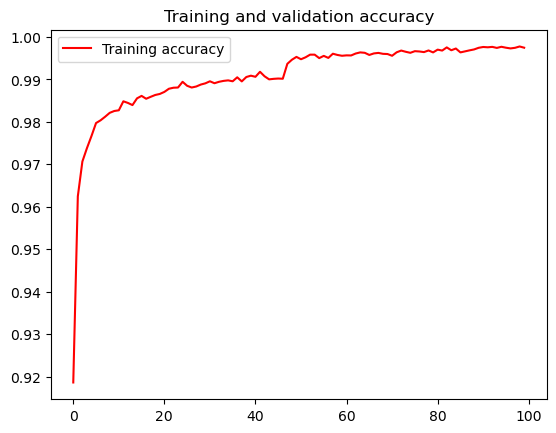

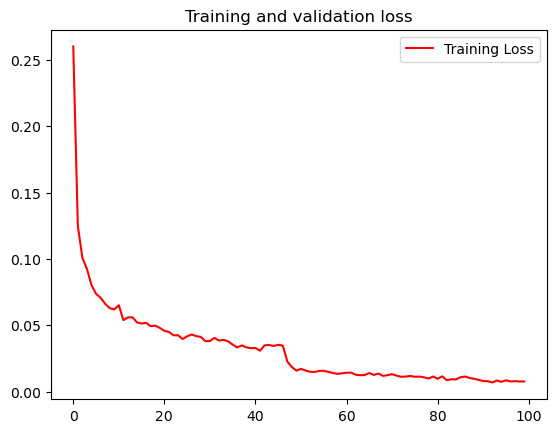

In [15]:
acc = history.history['accuracy']
#val_acc = history.history['val_accuracy']
loss = history.history['loss']
#val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
#plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
#plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Prediction
Prediction of Test data

In [16]:
prediction = model.predict(test_input)

235/235 [==============================] - 1s 2ms/step


# Plot
show the first 10 samples of the images

In [17]:
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

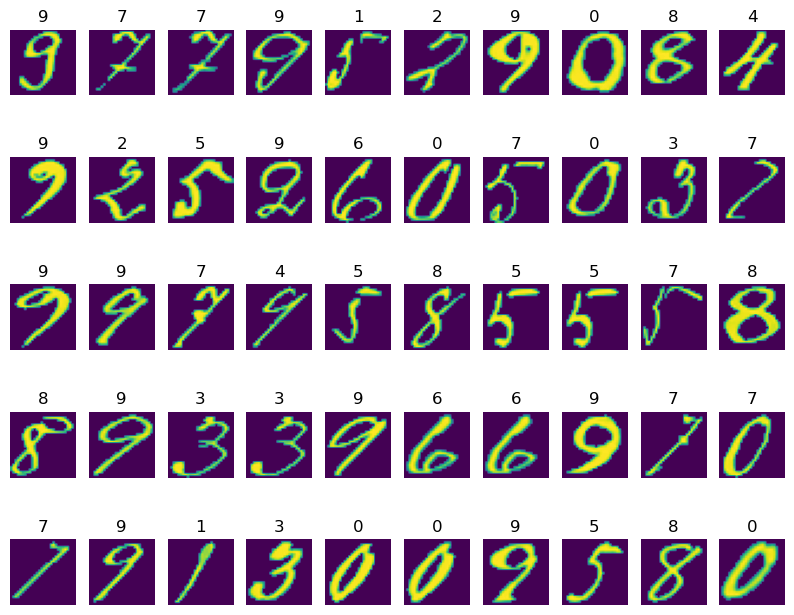

In [18]:
figure, axes = plt.subplots(5, 10, figsize=(10, 8))
axes = axes.ravel()

for index in range(0,50):
    axes[index].imshow(test_input[index])
    axes[index].set_title(np.argmax(prediction[index]))
    axes[index].axis("off")


## Prediction submission 

In [19]:
predicted_labels = np.argmax(prediction, axis=1)
data_df = {'Label': predicted_labels}
solution = pd.DataFrame(data=data_df, index=pd.RangeIndex(start=1, stop=len(test)+1, name='ImageId'))
solution.to_csv('submission.csv')